## visual response time

In [17]:
import json
import os

def get_files(model):
    current_folder = os.getcwd()
    folder = os.path.join(current_folder, 'cleaned')
    file_list = os.listdir(folder)
    files = [file for file in file_list if file.endswith('.json') and model in file]
    return folder, files 

In [5]:
get_files("tiiuae_")

('/data/CoS/cleaned', ['tiiuae_falcon-40b.json', 'tiiuae_falcon-7b.json'])

In [6]:
def read_time_token(folder, file):
    file_path = os.path.join(folder, file)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f) 
    times = [d["delay"] for d in data]
    tokens = [d["i_tokens"] for d in data]
    return times, tokens

In [7]:
import matplotlib.pyplot as plt

def plot_Scatter(times, tokens, model):
    plt.figure(figsize=(6, 4))
    plt.scatter(tokens, times, color='blue')
    plt.title('Scatter Plot of {}'.format(model))
    plt.xlabel('tokens')
    plt.ylabel('times')
    plt.grid(True)
    plt.show()

In [ ]:
current_folder, files = get_files('')
for file in files:
    times, tokens = read_time_token(current_folder, file)
    plot_Scatter(times, tokens, file.replace(".json", ""))


In [16]:
def read_time_all_tokens(folder, file):
    file_path = os.path.join(folder, file)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f) 
    times = [d["delay"] for d in data]
    tokens = [d["i_tokens"]+d['o_tokens'] for d in data]
    return times, tokens

In [ ]:
current_folder, files = get_files('')
for file in files:
    times, tokens = read_time_all_tokens(current_folder, file)
    plot_Scatter(times, tokens, file.replace(".json", ""))

In [20]:
from scipy.stats import pearsonr, spearmanr, kendalltau
import numpy as np

def correlation(list1, list2):
    arr1 = np.array(list1)
    arr2 = np.array(list2)
    pear, _ = pearsonr(arr1, arr2)
    spear, _ = spearmanr(arr1, arr2)
    kendal, _ = kendalltau(arr1, arr2)
    # print("pear: {}, spear: {}, kendal: {}".format(pear, spear, kendal))
    return pear, spear, kendal

In [25]:
def corr_of_models(all_tokens):
    models, pears, spears = [], [], []
    current_folder, files = get_files('')
    for file in files:
        if all_tokens:
            times, tokens = read_time_token(current_folder, file)
        else: 
            times, tokens = read_time_all_tokens(current_folder, file)
        pear, spear, kendal = correlation(times, tokens)
        models.append(file.replace(".json", ""))
        pears.append(pear)
        spears.append(spear)
    return models, pears, spears

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


def plot_corr(models, pears, spears):
    fig, ax = plt.subplots(figsize=(8, 6))
    # Bar width
    width = 0.3

    # Bar positions
    x = range(len(models))
    ax.set_ylim(-1, 1)
    ax.bar(x, pears, width=width, label='pears')
    ax.bar([i + width for i in x], spears, width=width, label='spears')
    plt.axhline(y=0.5, color='red', linestyle='--')

    ax.set_ylabel('Correlation Coefficient')

    i = 0
    for pear in pears:
        ax.text(i - 0.1, pears[i], f"{pears[i]:.2f}", fontsize=8, ha='center')
        i += 1
    for i in x:
        ax.text(i + 0.3, spears[i], f"{spears[i]:.2f}", fontsize=8, ha='center')

    ax.set_xticks([i + width for i in x])
    ax.set_xticklabels(models, rotation=90)
    ax.legend()

    plt.tight_layout()
    plt.show()

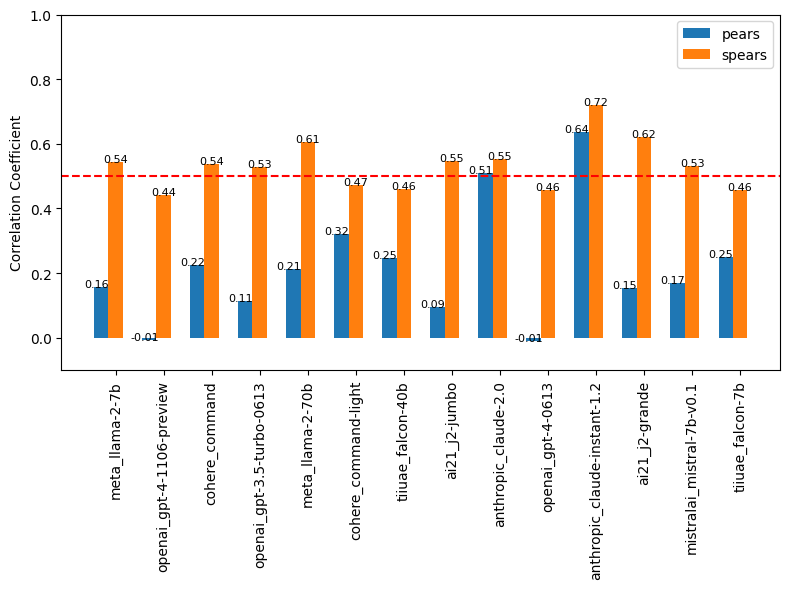

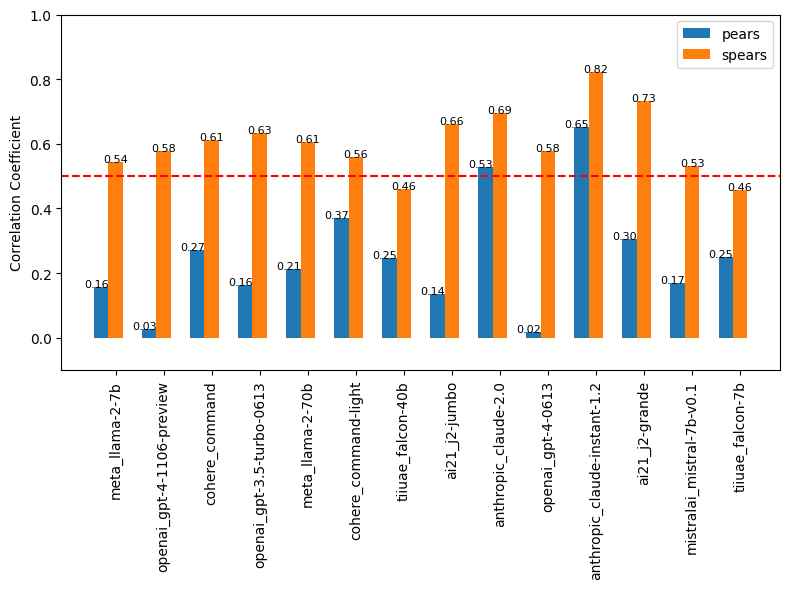

In [23]:
choose_all_tokens = True
models, pears, spears = corr_of_models(choose_all_tokens)
plot_corr(models, pears, spears)

choose_all_tokens = False
models, pears, spears = corr_of_models(choose_all_tokens)
plot_corr(models, pears, spears)

#### 结论
response_time 和输入输出tokens数量没有明显线性关系, 符合散点图

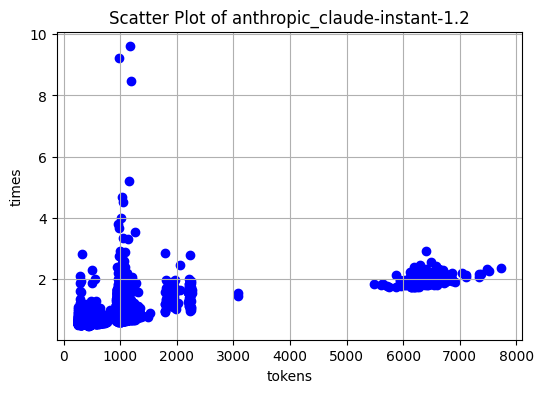

In [24]:
file = "/data/CoS/cleaned/anthropic_claude-instant-1.2.json"
with open(file, 'r', encoding='utf-8') as f:
    data = json.load(f) 
    times = [d["delay"] for d in data]
    tokens = [d["i_tokens"] for d in data]
plot_Scatter(times, tokens, "anthropic_claude-instant-1.2")

In [ ]:
current_folder, files = get_files('')
all_data = list()
for file in files:
    times, tokens = read_time_token(current_folder, file)
    all_data.append(times)
    plot_Scatter(times, tokens, file.replace(".json", ""))
    
# 绘制小提琴图
plt.figure(figsize=(8, 6))
plt.violinplot(data)
plt.title('Violin Plot of Delays')
plt.xlabel('Dataset')
plt.ylabel('Delay')
plt.xticks([1, 2, 3], ['Data1', 'Data2', 'Data3'])
plt.grid(True)
plt.show()

## 求最大序列长度

In [7]:
from transformers import DistilBertTokenizerFast
def count_tokens(text):
    tokenizer = DistilBertTokenizerFast.from_pretrained('/data/CoS/ptm/distilbert-base-uncased')
    # 使用 tokenizer 对文本进行标记化
    tokens = tokenizer.tokenize(text)
    return len(tokens)

In [8]:
text="i love china !"
count_tokens(text)

4

In [11]:
def max_token_on_file(data):
    all_tokens = []
    for d in data:
        if d['subset']:
            task = d["task"]+"-"+d["subset"]
        else:
            task = d["task"]
        tokens = count_tokens("query:{}#model:{}#task:{}".format(d["query"], d["model"], task))
        all_tokens.append(tokens)
    return max(all_tokens)

In [12]:
current_folder, files = get_files('')
for file in files:
    file_path = os.path.join(current_folder, file)
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f) 
        tokens = max_token_on_file(data)
        print("{}'s max tokens: {}".format(file.replace('.json', ''), tokens))

meta_llama-2-7b's max tokens: 3186
openai_gpt-4-1106-preview's max tokens: 3189
cohere_command's max tokens: 3182
openai_gpt-3.5-turbo-0613's max tokens: 3191
meta_llama-2-70b's max tokens: 3186
cohere_command-light's max tokens: 3184


KeyboardInterrupt: 

In [13]:
# meta_llama-2-7b's max tokens: 3186
# openai_gpt-4-1106-preview's max tokens: 3189
# cohere_command's max tokens: 3182
# openai_gpt-3.5-turbo-0613's max tokens: 3191
# meta_llama-2-70b's max tokens: 3186
# cohere_command-light's max tokens: 3184

In [8]:
def freq_tokens(data):
    dic = {}
    for d in data:
        if d['i_tokens'] in dic:
            dic[d['i_tokens']] += 1
        else:
            dic[d['i_tokens']] = 1
    return dict(sorted(dic.items(), key=lambda item: item[0]))

In [10]:
import json
file = "/data/CoS/cleaned/anthropic_claude-instant-1.2.json"
with open(file, 'r', encoding='utf-8') as f:
    data = json.load(f) 
freq_tokens(data)

{255: 4,
 256: 16,
 257: 14,
 258: 20,
 259: 17,
 260: 14,
 261: 2,
 262: 3,
 263: 2,
 264: 1,
 265: 1,
 272: 1,
 283: 10,
 284: 3,
 285: 14,
 286: 3,
 287: 1,
 288: 17,
 289: 23,
 290: 6,
 291: 4,
 292: 1,
 293: 13,
 294: 49,
 295: 38,
 296: 28,
 297: 24,
 298: 17,
 299: 20,
 300: 68,
 301: 28,
 302: 74,
 303: 60,
 304: 56,
 305: 34,
 306: 19,
 307: 111,
 308: 44,
 309: 33,
 310: 38,
 311: 7,
 312: 16,
 313: 17,
 314: 18,
 315: 19,
 316: 3,
 317: 1,
 318: 2,
 319: 14,
 320: 2,
 321: 2,
 322: 12,
 323: 15,
 324: 8,
 325: 2,
 326: 1,
 327: 14,
 328: 6,
 329: 4,
 332: 1,
 361: 1,
 363: 2,
 365: 2,
 366: 2,
 367: 2,
 368: 2,
 369: 2,
 371: 1,
 372: 1,
 374: 2,
 375: 3,
 376: 5,
 377: 3,
 378: 2,
 379: 5,
 380: 2,
 381: 1,
 382: 3,
 383: 1,
 384: 3,
 385: 1,
 386: 4,
 387: 1,
 388: 4,
 389: 3,
 390: 2,
 392: 1,
 393: 2,
 396: 2,
 397: 1,
 400: 2,
 401: 2,
 402: 4,
 403: 1,
 404: 2,
 405: 7,
 406: 8,
 407: 3,
 408: 11,
 409: 3,
 410: 5,
 411: 5,
 412: 6,
 413: 7,
 414: 6,
 415: 3,
 416: 6,


In [44]:
import json
import pandas as pd


def get_all_df():
    current_folder, files = get_files('')
    times, tokens, models = [], [], []
    for file in files:
        file_path = os.path.join(current_folder, file)
        with open(file_path, 'r', encoding='utf-8') as f:
            data = json.load(f) 
        single_model_times = [d["delay"] for d in data if d["delay"]<10]
        single_model_tokens = [d["i_tokens"] for d in data]
        times.append(single_model_times)
        tokens.append(single_model_tokens)
        models.append(file.replace('.json', ""))
    return times,tokens, models 

In [41]:
import numpy as np
import matplotlib.pyplot as plt

def plot_box(merged_data, models):
    # plt.figure(figsize=(10, 6))
    fig, ax = plt.subplots(figsize=(8, 6))
    x = range(len(models))
    # sns.violinplot(data=merged_data, x=models, y='delay')
    ax.boxplot(merged_data)
    # plt.title('Distribution of Delay Times for Each Model')
    ax.set_ylabel('Delay Times')
    # ax.set_xticks([i + width for i in x])
    ax.set_xticks(np.arange(1, len(models) + 1), labels=models)
    ax.set_xticklabels(models, rotation=90)
    ax.legend()
    plt.tight_layout()
    plt.show()

In [45]:
times, tokens, models = get_all_df()
print(len(models))

14


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


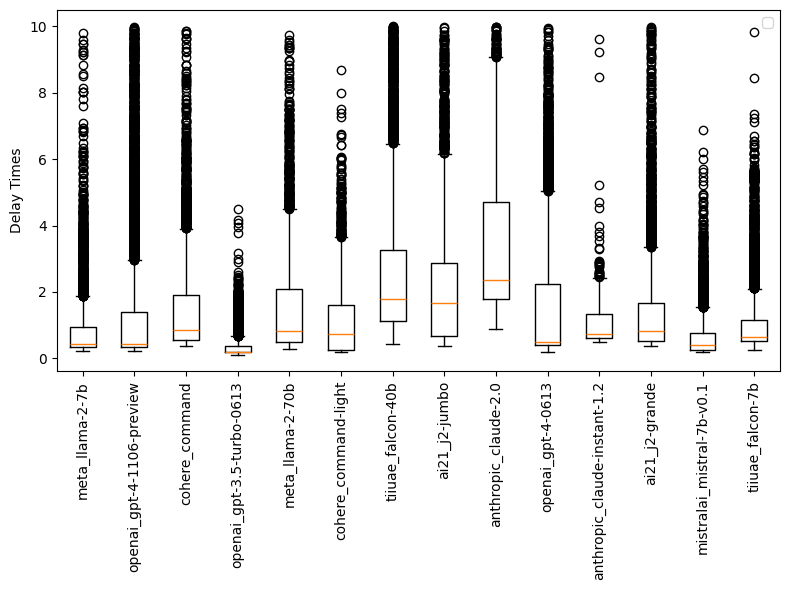

In [46]:
##去除响应时间超过10s的
plot_box(times, models)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


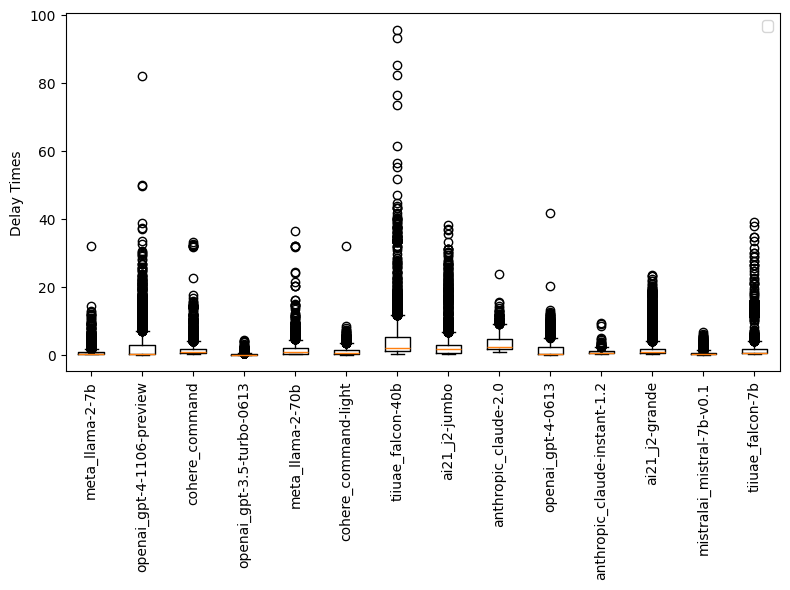

In [39]:
plot_box(times, models)